#verify pyEMU null space projection with the freyberg problem

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu

setting random seed


instaniate ```pyemu``` object and drop prior info.  Then reorder the jacobian and save as binary.  This is needed because the pest utilities require strict order between the control file and jacobian

In [2]:
mc = pyemu.MonteCarlo(jco="freyberg.jcb",verbose=False,forecasts=[])
mc.drop_prior_information()
jco_ord = mc.jco.get(mc.pst.obs_names,mc.pst.par_names)
ord_base = "freyberg_ord"
jco_ord.to_binary(ord_base + ".jco")  
mc.pst.control_data.parsaverun = ' '
mc.pst.write(ord_base+".pst")
nsing = 5

Draw some vectors from the prior and write the vectors to par files

In [3]:
# setup the dirs to hold all this stuff
par_dir = "prior_par_draws"
proj_dir = "proj_par_draws"
parfile_base = os.path.join(par_dir,"draw_")
projparfile_base = os.path.join(proj_dir,"draw_")
if os.path.exists(par_dir):
   shutil.rmtree(par_dir)
os.mkdir(par_dir)
if os.path.exists(proj_dir):
   shutil.rmtree(proj_dir)
os.mkdir(proj_dir)
mc = pyemu.MonteCarlo(jco=ord_base+".jco")
# make some draws
mc.draw(10)
#for i in range(10):
#    mc.parensemble.iloc[i,:] = i+1
#write them to files
mc.parensemble.index = [str(i+1) for i in range(mc.parensemble.shape[0])]
mc.parensemble.to_parfiles(parfile_base)
mc.parensemble.shape

E:\git\pyemu\pyemu\en.py:538: UserWarning: deprecation warning: enforce_bounds should be either 'reset' or 'drop', not bool.  resetting to 'reset'.
  " to 'reset'.")


(10, 761)

Run pnulpar

In [4]:
exe = os.path.join("pnulpar.exe")
args = [ord_base+".pst","y",str(nsing),"y","pnulpar_qhalfx.mat",parfile_base,projparfile_base]
in_file = os.path.join("misc","pnulpar.in")
with open(in_file,'w') as f:
    f.write('\n'.join(args)+'\n') 
os.system(exe + ' <'+in_file)


0

In [5]:
pnul_en = pyemu.ParameterEnsemble(mc.pst)
parfiles =[os.path.join(proj_dir,f) for f in os.listdir(proj_dir) if f.endswith(".par")]
pnul_en.read_parfiles(parfiles)

In [6]:
pnul_en.loc[:,"fname"] = pnul_en.index
pnul_en.index = pnul_en.fname.apply(lambda x:str(int(x.split('.')[0].split('_')[-1])))
f = pnul_en.pop("fname")

In [7]:

pnul_en.sort_index(axis=1,inplace=True)
pnul_en.sort_index(axis=0,inplace=True)
pnul_en

parnme,hkr00c00,hkr00c01,hkr00c02,hkr00c03,hkr00c04,hkr00c05,hkr00c06,hkr00c07,hkr00c08,hkr00c09,...,wf2_1,wf2_2,wf3_1,wf3_2,wf4_1,wf4_2,wf5_1,wf5_2,wf6_1,wf6_2
fname,,,,,,,,,,,,,,,,,,,,,
1,0.632508,31.093010,12.498050,13.029710,1.357230,23.774430,5.953002,1.277483,24.662260,3.866367,...,342.8237,399.912,326.4032,260.327,77.65506,93.4162,68.42880,80.1577,340.7025,412.205
10,20.767050,12.776540,2.137331,3.188031,17.548690,23.029720,4.887922,14.090760,12.481990,4.650727,...,318.8160,491.491,303.2640,537.904,64.54079,97.4227,68.42880,106.8990,408.6720,331.957
2,0.632991,11.509680,8.118226,2.871934,13.200940,2.998956,7.192511,9.952804,2.390484,2.713398,...,318.8160,514.360,303.2640,336.300,64.54079,131.5500,63.50110,65.2855,378.7536,318.332
3,1.191746,5.647212,1.740148,22.295470,22.576120,3.594616,3.655955,22.055270,8.112185,3.641538,...,318.8160,458.492,303.2640,347.959,67.15486,86.9300,68.42880,98.9299,379.4942,696.600
4,0.594751,9.169407,24.316410,4.068674,8.236016,1.520855,27.076710,1.600563,3.393597,13.348280,...,318.8160,609.563,303.2640,381.702,64.54079,116.5370,68.42880,81.4748,358.7519,465.587
5,27.906710,0.594751,20.281290,0.594751,27.110800,20.097810,26.479200,0.594751,1.324676,3.485513,...,318.8160,394.960,303.2640,422.575,64.54079,78.2804,62.64327,90.0925,341.1433,654.814
6,0.700632,32.963700,13.607160,2.288246,12.433390,3.069993,3.060993,5.047338,6.487807,0.594751,...,318.8160,438.401,325.1447,451.019,78.88320,90.1760,68.42880,66.9067,334.3680,358.766
7,0.594751,11.609580,4.122848,0.594751,10.320540,0.815150,30.429370,0.594751,12.680110,3.004708,...,318.8160,365.641,303.2640,427.020,64.54079,134.4600,68.42880,55.8086,342.6499,232.200
8,20.176160,13.722200,34.944350,10.966290,2.203151,27.483920,2.465113,1.990630,2.145425,6.230356,...,318.8160,269.556,303.2640,442.595,77.14167,116.4390,68.42880,61.5077,334.3680,555.626


Now for pyemu

In [8]:
print(mc.parensemble.istransformed)
mc.parensemble._transform()
en = mc.project_parensemble(nsing=nsing,inplace=False)
print(mc.parensemble.istransformed)
#en._back_transform()

False
using 5 singular components
True


In [9]:
en.sort_index(axis=1,inplace=True)
en.sort_index(axis=0,inplace=True)
en

parnme,hkr00c00,hkr00c01,hkr00c02,hkr00c03,hkr00c04,hkr00c05,hkr00c06,hkr00c07,hkr00c08,hkr00c09,...,wf2_1,wf2_2,wf3_1,wf3_2,wf4_1,wf4_2,wf5_1,wf5_2,wf6_1,wf6_2
1,0.632509,31.093,12.498,13.0297,1.35724,23.7745,5.95301,1.27749,24.6622,3.86637,...,342.824,399.912,326.403,260.327,77.6551,93.4162,68.4288,80.1577,340.703,412.205
10,20.767,12.7765,2.13733,3.18803,17.5487,23.0297,4.88792,14.0908,12.482,4.65074,...,318.816,491.491,303.264,537.904,64.5408,97.4227,68.4288,106.899,408.672,331.957
2,0.632991,11.5097,8.11822,2.87193,13.201,2.99895,7.19251,9.9528,2.39048,2.7134,...,318.816,514.36,303.264,336.3,64.5408,131.55,63.5011,65.2855,378.754,318.332
3,1.19175,5.64721,1.74015,22.2955,22.5761,3.59461,3.65595,22.0552,8.11218,3.64153,...,318.816,458.492,303.264,347.959,67.1549,86.93,68.4288,98.9299,379.494,696.6
4,0.594751,9.16941,24.3164,4.06867,8.23601,1.52085,27.0767,1.60056,3.3936,13.3483,...,318.816,609.563,303.264,381.702,64.5408,116.537,68.4288,81.4748,358.752,465.587
5,27.9067,0.594751,20.2812,0.594751,27.1108,20.0978,26.4792,0.594751,1.32468,3.48552,...,318.816,394.96,303.264,422.575,64.5408,78.2804,62.6433,90.0925,341.143,654.814
6,0.700633,32.9637,13.6072,2.28825,12.4334,3.06999,3.06099,5.04733,6.4878,0.594751,...,318.816,438.401,325.145,451.019,78.8832,90.176,68.4288,66.9067,334.368,358.766
7,0.594751,11.6096,4.12285,0.594751,10.3206,0.815147,30.4293,0.594751,12.6802,3.00471,...,318.816,365.641,303.264,427.02,64.5408,134.46,68.4288,55.8086,342.65,232.2
8,20.1762,13.7222,34.9444,10.9663,2.20315,27.4839,2.46512,1.99063,2.14543,6.23036,...,318.816,269.556,303.264,442.595,77.1417,116.439,68.4288,61.5077,334.368,555.626
9,0.607529,0.615923,0.784533,40.3929,0.919738,6.26473,0.779907,0.601123,0.594751,0.594751,...,318.816,514.038,303.264,474.417,72.7245,57.1967,68.4288,63.6205,354.049,396.588


parnme,hkr00c00,hkr00c01,hkr00c02,hkr00c03,hkr00c04,hkr00c05,hkr00c06,hkr00c07,hkr00c08,hkr00c09,...,wf2_1,wf2_2,wf3_1,wf3_2,wf4_1,wf4_2,wf5_1,wf5_2,wf6_1,wf6_2
fname,,,,,,,,,,,,,,,,,,,,,
1,4.44515e-05,2.50218e-05,0.000229813,0.000295332,0.000380811,8.90898e-05,9.79158e-05,0.000415798,4.58928e-05,0.000133425,...,2.67343e-05,1.62221e-05,1.9351e-05,6.99558e-05,1.59878e-05,4.57256e-05,0,4.74764e-05,1.1278e-05,4.84934e-05
10,0.000157395,7.11027e-07,3.27536e-05,5.68306e-05,2.23101e-06,7.56212e-05,8.62068e-05,0.000349497,1.06366e-05,0.000195546,...,0,6.99203e-05,0,5.67339e-05,0,5.40094e-06,0,1.15337e-06,0,5.98897e-05
2,6.47828e-06,4.09547e-05,3.88728e-05,0.000276055,0.000314253,0.000168122,7.99438e-06,2.99139e-05,6.94172e-05,0.000252718,...,0,5.80766e-05,0,0.000146458,0,1.85109e-05,5.78784e-05,4.85077e-05,6.21367e-06,1.19799e-05
3,0.00023746,9.76909e-06,8.53339e-05,0.000140516,0.00010524,0.000123372,0.000146324,0.000186107,0.000113734,0.000215805,...,0,2.66916e-05,0,0.000127812,5.17545e-05,4.83752e-05,0,3.11606e-05,1.32752e-05,0
4,1.8667e-14,5.37199e-06,6.14801e-06,0.000175277,0.000130679,0.000574039,8.34805e-05,0.000336375,4.34514e-05,0.000284976,...,0,1.89342e-05,0,1.97254e-05,0,0.000300042,0,5.99848e-05,8.70785e-06,2.52187e-05
5,8.75862e-05,1.8667e-14,0.000200229,1.8667e-14,5.5205e-05,0.000146678,4.30792e-05,1.8667e-14,7.93003e-05,9.65421e-05,...,0,4.43016e-05,0,5.62861e-05,0,3.48971e-05,8.58167e-06,3.52912e-05,2.20445e-05,6.78635e-05
6,4.52121e-05,5.64582e-05,0.000160531,3.69198e-05,0.000293216,6.11159e-05,6.86387e-05,0.000148987,5.95935e-05,1.8667e-14,...,0,4.61318e-05,1.68775e-05,8.15667e-05,0,4.63772e-05,0,6.44305e-05,0,7.55365e-05
7,1.8667e-14,0.000442466,5.50868e-05,1.8667e-14,0.000156393,0.000405876,0.00012747,1.8667e-14,0.000338666,9.24477e-05,...,0,6.64623e-05,0,9.23181e-05,0,0,0,5.80518e-05,9.87024e-06,7.83372e-13
8,3.56322e-05,0.000150717,5.6017e-05,2.10271e-05,0.000117732,0.00015124,0.000161189,0.000176354,0.000276099,1.14096e-05,...,0,0.000166933,0,4.98019e-06,2.07612e-05,0.000177232,0,8.07484e-06,0,6.32617e-05


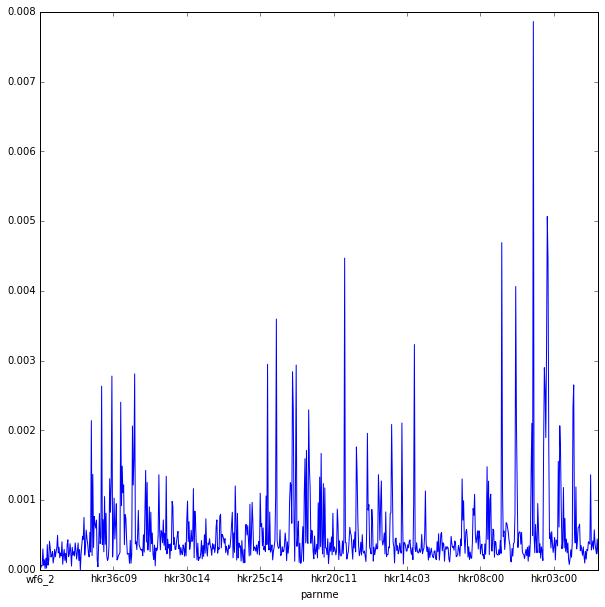

In [10]:
#pnul_en.sort(inplace=True)
#en.sort(inplace=True)
diff = 100.0 * np.abs(pnul_en - en) / en

#diff[diff<1.0] = np.NaN
dmax = diff.max(axis=0)
dmax.sort_index(ascending=False,inplace=True)
dmax.plot(figsize=(10,10))
diff

In [11]:
en.loc[:,"wf6_2"]

1     412.205
10    331.957
2     318.332
3       696.6
4     465.587
5     654.814
6     358.766
7       232.2
8     555.626
9     396.588
Name: wf6_2, dtype: object

In [12]:
pnul_en.loc[:,"wf6_2"]

fname
1     412.205
10    331.957
2     318.332
3     696.600
4     465.587
5     654.814
6     358.766
7     232.200
8     555.626
9     396.588
Name: wf6_2, dtype: float64